### Mixed ANOVA

Based on [McDermott et al (2016)](https://www.nature.com/articles/nature18635)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.stats import f

# Set styles for plotting
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of subjects and levels
n_subjects = [47,50] # number of participants for US and Tsimane respectively
groups = ['US','Tsimane']
n_groups = len(groups)
levels_chord = ['Consonant','Dissonant']
n_chord = len(levels_chord)

# Mean values and standard deviation for each level
# Based values on Fig 3
means = np.array([[2.9, 2], [3, 3]]) # columns are Cons / Diss, rows are US / Tsimane
std_dev_sbj = 0.5 # this is the st. dev. across participants
std_dev_wthn = 0.3 # this is the st. dev. within participants

data = []
for subject in range(0, sum(n_subjects)):
    sbj_avg = np.random.normal(0, std_dev_sbj)
    grp_idx = int((subject+1)>n_subjects[0])
    for chord in range(0, n_chord):
        value = np.random.normal(means[grp_idx,chord], std_dev_wthn)
        value = value+sbj_avg  
        value = max(1,min(4,value)) # make sure the value is between 0 and 4
        data.append([subject+1, groups[grp_idx], levels_chord[chord], value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Subject', 'Group', 'Chord', 'Pleasantness'])
df.describe(include='all')

,Subject,Group,Chord,Pleasantness
count,194.000000,194,194,194.000000
unique,NaN,2,2,NaN
top,NaN,Tsimane,Consonant,NaN
freq,NaN,100,97,NaN
mean,49.000000,NaN,NaN,2.749042
std,28.072445,NaN,NaN,0.659847
min,1.000000,NaN,NaN,1.104891
25%,25.000000,NaN,NaN,2.319079
50%,49.000000,NaN,NaN,2.757046
75%,73.000000,NaN,NaN,3.220857


[<Axes: title={'center': 'Group = US'}, xlabel='Chord', ylabel='Pleasantness'>
 <Axes: title={'center': 'Group = Tsimane'}, xlabel='Chord'>]


AttributeError: 'numpy.ndarray' object has no attribute 'set'

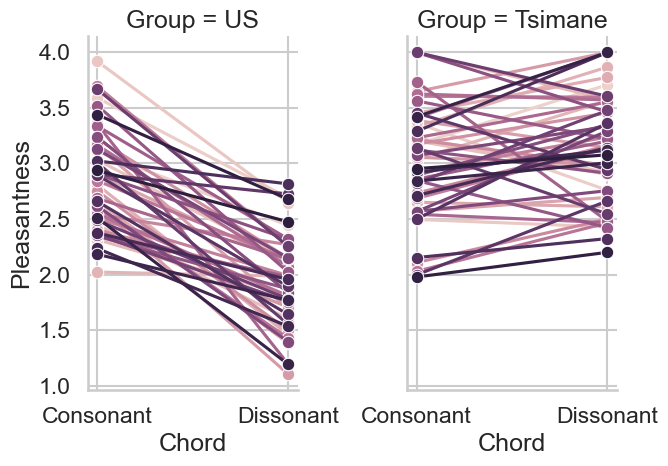

In [16]:
# Plot the data
g = sns.FacetGrid(data=df, col='Group', height=5, aspect=0.7)
pl = g.map_dataframe(sns.lineplot, x='Chord', y='Pleasantness', hue='Subject', marker='o')
print(pl.axes[0])
pl.axes[0].set(palette="crest")
pl = g.map_dataframe(sns.lineplot, x='Chord', y='Pleasantness', hue='Subject', marker='o')
pl.axes[0].set(palette="flare")
plt.tight_layout()
plt.show()

In [12]:
sns.color_palette("crest")

[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

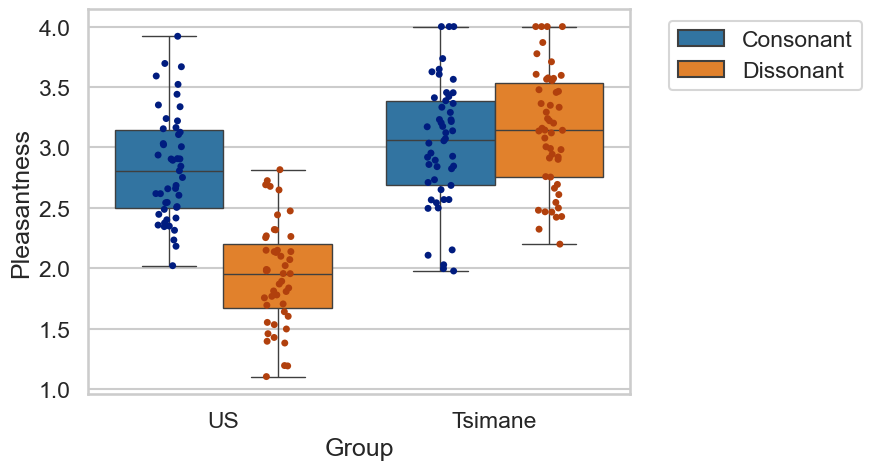

In [15]:
# Overlay both conditions, using a boxplot and strip plot
plt.figure(figsize=(7,5))
boxplot = sns.boxplot(data=df, x='Group', hue='Chord', y='Pleasantness')
handles, labels = boxplot.get_legend_handles_labels()
sns.stripplot(data=df, x='Group', hue='Chord', y='Pleasantness', dodge=True, palette='dark')
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [16]:
# Run the repeated-measures ANOVA
aov = pg.mixed_anova(dv='Pleasantness', between='Group', within='Chord', subject='Subject', data=df, effsize="ng2")
# Display the overall results
print(aov)

        Source         SS  DF1  DF2         MS           F         p-unc  \
0        Group  22.980648    1   95  22.980648   66.479977  1.427910e-12   
1        Chord   6.740990    1   95   6.740990   69.086204  6.603390e-13   
2  Interaction  12.201265    1   95  12.201265  125.046770  5.055065e-19   

        ng2  eps  
0  0.353062  NaN  
1  0.137994  1.0  
2  0.224659  NaN  


### Test for sphericity

In [11]:
# Display the result of Mauchly's test for sphericity
spher, W, chi2, dof, pval = pg.sphericity(data=df, dv='Response time', within='Chord', subject='Subject')
print(f'Sphericity: W = {W:.3f}, dof = {dof}, p = {pval:.3f}')

Sphericity: W = nan, dof = 1, p = 1.000


### Multiple comparisons

In [17]:
# Calculate expected marginal means
# Pairwise Comparisons
posthocs = pg.pairwise_tests(dv='Pleasantness', between='Group', within='Chord', subject='Subject', data=df, 
                             padjust='bonf', within_first=False)
print(posthocs)

        Contrast    Group          A          B Paired Parametric          T  \
0          Group        -    Tsimane         US  False       True   8.200039   
1          Chord        -  Consonant  Dissonant   True       True   5.490018   
2  Group * Chord  Tsimane  Consonant  Dissonant   True       True  -1.832217   
3  Group * Chord       US  Consonant  Dissonant   True       True  13.689517   

         dof alternative         p-unc        p-corr p-adjust       BF10  \
0  93.641865   two-sided  1.240614e-12           NaN      NaN  5.213e+09   
1  96.000000   two-sided  3.276596e-07           NaN      NaN  4.005e+04   
2  49.000000   two-sided  7.300010e-02  1.460002e-01     bonf      0.722   
3  46.000000   two-sided  7.774254e-18  1.554851e-17     bonf  7.096e+14   

     hedges  
0  1.643410  
1  0.585296  
2 -0.224728  
3  2.024102  
